Cumulative MSE: 2.2705910208242
Total Transmissions (Oracle): 472
Total Transmissions (Normal): 236


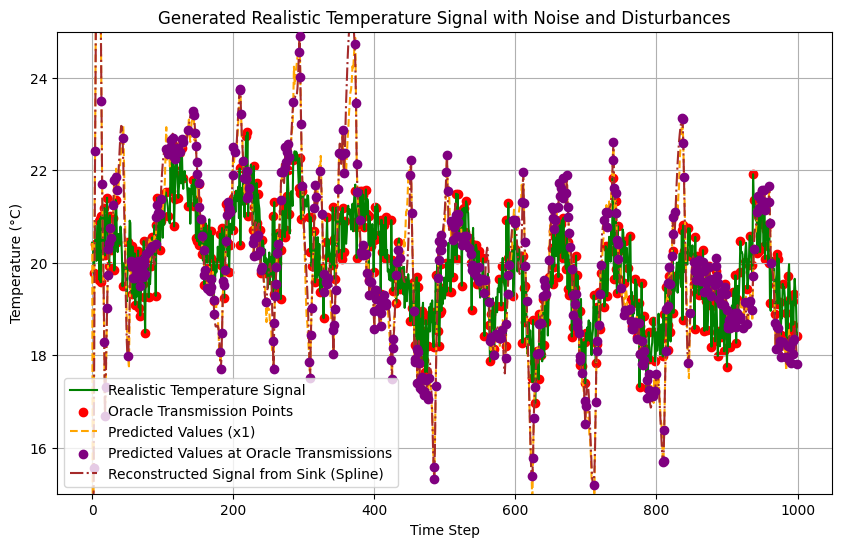

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 1
    cumulative_mse = 0
    oracle_transmission_count = 0
    voi_mse_list = []
    
    # Initialize the oracle's last transmitted value
    normal_transmission_count = 0
    oracle_last_transmitted_value = z_temp[0]
    predicted_values = [z_temp[0]]  # Initialize with the first value (for t=0)
    oracle_transmission_times = []  # To store the times when oracle transmits
    predicted_at_transmissions = []  # To store predicted values at oracle transmission points
    transmitted_values = []  # To store transmitted values (x1 and x2)
    last_transmission_time = 0

    x1, x2 = update_node_state_dewma(z_temp[0], last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)
    last_state_value = x1
    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        #last_state_value = measured_value
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)
        delta_t= t-last_transmission_time
        predicted_value = x1
        # Calculate the predicted value using the rate of change and time elapsed
        #predicted_value = last_state_value + (last_rate_of_change * delta_t)
        predicted_values.append(predicted_value)
        #predicted_values.append(x1)
        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(last_state_value - x1) > threshold:
            normal_transmission_count += 1
            last_state_value = x1
            last_rate_of_change = x2
            
            #last_transmission_time = t

        if np.abs(measured_value - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = measured_value  # Update the last transmitted value
            oracle_transmission_times.append(t)  # Store the time of oracle transmission
            predicted_at_transmissions.append(x1)  # Store the predicted value at this transmission point
            transmitted_values.append((t, x1, x2))  # Store both x1 and x2 at the transmission points
            
            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(predicted_value, measured_value)
            cumulative_mse += mse
            oracle_transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis
            last_transmission_time = t

        # Update the estimated state
        

    cumulative_mse = cumulative_mse / oracle_transmission_count

    return cumulative_mse, oracle_transmission_count,normal_transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, predicted_at_transmissions, transmitted_values


# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)

    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic


# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 200  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 0.5  # Amplitude of the noise
disturbance_probability = 0  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the push-based system
threshold = 0.5  # Threshold for VoI
beta_1 = 0.3  # dEWMA beta_1
beta_2 = 0.3  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, oracle_transmission_count, normal_transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, predicted_at_transmissions, transmitted_values = push_based_system_voi(T_realistic, total_time, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {oracle_transmission_count}")
print(f"Total Transmissions (Normal): {normal_transmission_count}")

# Plot the MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
"""plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Push-based System and Oracle at Transmission Points")
plt.legend()
plt.grid(True)
"""
# Plot the generated temperature signal with noise and disturbances
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Realistic Temperature Signal with Noise and Disturbances")
plt.ylim(15, 25)

# Highlight the points where the oracle transmits (VoI condition met)
plt.scatter(oracle_transmission_times, np.array(T_realistic)[oracle_transmission_times], color='red', label='Oracle Transmission Points')

# Plot the predicted values (based on x1 from dEWMA)
plt.plot(t, predicted_values, label="Predicted Values (x1)", color='orange', linestyle='--')

# Plot the predicted values at oracle transmission points (x1 at transmission times)
plt.scatter(oracle_transmission_times, predicted_at_transmissions, color='purple', label="Predicted Values at Oracle Transmissions", zorder=5)

# Reconstruct the temperature path using spline interpolation from transmitted data
transmitted_times, transmitted_x1_values, transmitted_x2_values = zip(*transmitted_values)

# Spline fitting: Use cubic spline interpolation to reconstruct the signal
spline_reconstruction = CubicSpline(transmitted_times, transmitted_x1_values, bc_type='natural')
reconstructed_signal = spline_reconstruction(t)

# Plot the reconstructed signal
plt.plot(t, reconstructed_signal, label="Reconstructed Signal from Sink (Spline)", color='brown', linestyle='-.')

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Helper function to update state using dEWMA
def update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2):
    x1 = beta_1 * measured_value + (1 - beta_1) * (last_state_value + last_rate_of_change * delta_t)
    x2 = beta_2 * (x1 - last_state_value) / delta_t + (1 - beta_2) * last_rate_of_change
    return x1, x2

# MSE function to compare the oracle's true value and the estimated value
def mse_between_estimate_and_true(oracle_value, estimated_value):
    return (oracle_value - estimated_value) ** 2

# Function to simulate the push-based system with VoI calculation
def push_based_system_voi(z_temp, time_steps, threshold, beta_1, beta_2, delta_t):
    last_state_value = 0
    last_rate_of_change = 0
    cumulative_mse = 0
    transmission_count = 0
    voi_mse_list = []
    
    # Initialize the oracle's last transmitted value
    oracle_last_transmitted_value = z_temp[0]
    predicted_values = [z_temp[0]]  # Initialize with the first value (for t=0)
    oracle_transmission_times = []  # To store the times when oracle transmits
    predicted_at_transmissions = []  # To store predicted values at oracle transmission points
    transmitted_values = []  # To store transmitted values (x1 and x2)

    for t in range(1, time_steps):
        # Update the state with dEWMA
        measured_value = z_temp[t]
        x1, x2 = update_node_state_dewma(measured_value, last_state_value, last_rate_of_change, delta_t, beta_1, beta_2)

        # Calculate the predicted value using the rate of change and time elapsed
        predicted_value = last_state_value + (last_rate_of_change * delta_t)
        predicted_values.append(predicted_value)

        # Oracle decision (transmit only if VoI > threshold)
        if np.abs(measured_value - oracle_last_transmitted_value) > threshold:
            oracle_transmit = 1  # Oracle transmits
            oracle_last_transmitted_value = measured_value  # Update the last transmitted value
            oracle_transmission_times.append(t)  # Store the time of oracle transmission
            predicted_at_transmissions.append(x1)  # Store the predicted value at this transmission point
            transmitted_values.append((t, x1, x2))  # Store both x1 and x2 at the transmission points

            # Capture the push-based system's estimated value at this oracle transmission point
            mse = mse_between_estimate_and_true(predicted_value, measured_value)
            cumulative_mse += mse
            transmission_count += 1
            voi_mse_list.append((t, mse))  # Store time and MSE for analysis

        # Update the estimated state
        last_state_value = x1
        last_rate_of_change = x2

    cumulative_mse = cumulative_mse / time_steps

    return cumulative_mse, transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, predicted_at_transmissions, transmitted_values


# Generate realistic temperature signal with dynamic amplitude, random phase shifts, and irregular periods
def generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability):
    t = np.arange(0, total_time, time_resolution)

    amplitude_variation = 2 * np.sin(2 * np.pi * t / (7 * 24))  # Weekly amplitude variation
    random_phases = np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-np.pi, np.pi, 10))
    irregular_period = T_period + np.interp(t, np.linspace(0, total_time, 10), np.random.uniform(-2, 2, 10))
    omega = 2 * np.pi / irregular_period

    T_dynamic = amplitude_variation * np.sin(omega * t + random_phases) + T_avg
    noise = np.random.normal(0, noise_amplitude, len(t))
    disturbances = np.random.choice([0, np.random.uniform(-5, 5)], size=len(t), p=[1 - disturbance_probability, disturbance_probability])

    T_realistic = T_dynamic + noise + disturbances
    return t, T_realistic


# Parameters for the signal
total_time = 1000  # Total simulation time (in hours or time units)
time_resolution = 1  # Time step resolution (in hours or time units)
T_avg = 20  # Average temperature
T_period = 100  # Period of the temperature cycle (daily cycle, 24 hours)
noise_amplitude = 0.1  # Amplitude of the noise
disturbance_probability = 0  # Probability of a disturbance occurring at each time step

# Generate the realistic temperature signal
t, T_realistic = generate_realistic_temperature_signal(total_time, time_resolution, T_avg, T_period, noise_amplitude, disturbance_probability)

# Parameters for the push-based system
threshold = 0.5  # Threshold for VoI
beta_1 = 0.8  # dEWMA beta_1
beta_2 = 0.8  # dEWMA beta_2
delta_t = 1  # Time step for the rate of change

# Run the experiment for the push-based system with VoI calculation
cumulative_mse, transmission_count, voi_mse_list, predicted_values, oracle_transmission_times, predicted_at_transmissions, transmitted_values = push_based_system_voi(T_realistic, total_time, threshold, beta_1, beta_2, delta_t)

# Output Results
print(f"Cumulative MSE: {cumulative_mse}")
print(f"Total Transmissions (Oracle): {transmission_count}")

# Plot the MSE over time at the oracle's transmission points
times, mse_values = zip(*voi_mse_list)
plt.figure(figsize=(10, 6))
plt.plot(times, mse_values, label="MSE at Oracle Transmissions", color='blue')
plt.xlabel("Time Step")
plt.ylabel("MSE")
plt.title("MSE between Push-based System and Oracle at Transmission Points")
plt.legend()
plt.grid(True)

# Plot the generated temperature signal with noise and disturbances
plt.figure(figsize=(10, 6))
plt.plot(t, T_realistic, label="Realistic Temperature Signal", color='green')
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("Generated Realistic Temperature Signal with Noise and Disturbances")
plt.ylim(15, 25)

# Highlight the points where the oracle transmits (VoI condition met)
plt.scatter(oracle_transmission_times, np.array(T_realistic)[oracle_transmission_times], color='red', label='Oracle Transmission Points')

# Plot the predicted values (based on x1 from dEWMA)
plt.plot(t, predicted_values, label="Predicted Values (x1)", color='orange', linestyle='--')

# Plot the predicted values at oracle transmission points (x1 at transmission times)
plt.scatter(oracle_transmission_times, predicted_at_transmissions, color='purple', label="Predicted Values at Oracle Transmissions", zorder=5)

# Reconstruct the temperature path using spline interpolation from transmitted data
transmitted_times, transmitted_x1_values, transmitted_x2_values = zip(*transmitted_values)

# Spline fitting: Use cubic spline interpolation to reconstruct the signal
spline_reconstruction = CubicSpline(transmitted_times, transmitted_x1_values, bc_type='natural')
reconstructed_signal = spline_reconstruction(t)

# Plot the reconstructed signal
plt.plot(t, reconstructed_signal, label="Reconstructed Signal from Sink (Spline)", color='brown', linestyle='-.')

plt.legend()
plt.grid(True)
plt.show()
